## IDENTIFICATION OF NOVEL CLASSES OF NEOANTIGENS IN CANCER | Data preprocessing

In [1]:
%load_ext rpy2.ipython

## 0. Data preparation

This first cell should be modified according to the data that is going to be used. It is only available for datasets with paired samples per patient: normal and tumor. 

The **PROJECT** variable should be changed according to the GEO identifier.

From the GEO website, the *SRR_Acc_List.txt* and *SraRunTable.txt* files should be manually downloaded and save in a directory. This directory should be specified in **SRR** variable.

The pipeline is developed with the intention of running the most computationally expensive programs in a cluster. 
In this case, a Gluster File System has been used. The code to run on a cluster may need to be adapted.

In [ ]:
import os,re,shutil,glob,openpyxl
import pandas as pd
from Bio import SeqIO
from gtfparse import read_gtf
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
from IPython.display import Image

PROJECT="GSE193567"

cwd = os.getcwd()
DIR=os.path.join(cwd,"data",PROJECT)

try:
    os.makedirs(DIR) #path where to store all the itermediate steps and outputs of the pipeline
except:
    print("Directory for %s already exists" %PROJECT)
    
CLUSTERDIR="/users/genomics/marta" #path where to run and store things that run in a cluster
SRR="/projects_eg/datasets/"+PROJECT
SRR_ACC=os.path.join(SRR,"SRR_Acc_List.txt") 
SRA=os.path.join(SRR,"SraRunTable.txt")

FASTQDIR=os.path.join(DIR,"fastq_files") #path where to store fastq files
try:
    os.mkdir(FASTQDIR)
except:
    print("Fastq_files directory exists")
    
shutil.copy(SRR_ACC, os.path.join(FASTQDIR,"SRR_Acc_List.txt"))
shutil.copy(SRA, os.path.join(FASTQDIR,"SraRunTable.txt"))

GENOMEDIR=os.path.join(cwd, "genomes")

try:
    os.makedirs(os.path.join(DIR,"analysis"))
    os.makedirs(os.path.join(DIR,"results"))
    #os.makedirs(os.path.join(DIR,"scripts"))
except:
    print("Directory exists")



In [ ]:
%%R

require(tidyr)
require(dplyr)
require(rtracklayer)
#library(purrr)
require(ggplot2)
require(RColorBrewer)
require(devtools)
require(stringr)
require(edgeR)

Get a three column file with patient_id normal_id tumor_id for latter usage 

In [4]:
metadata = pd.read_csv(os.path.join(FASTQDIR.split("/fastq_files")[0],"SraRunTable.txt"))
metadata = metadata[['Run','Individual','tissue']]

normal = metadata[metadata['tissue'] == "non-tumor"]
normal = normal[['Individual','Run']]

tumor = metadata[metadata['tissue'] == "tumor"]
tumor = tumor[['Individual','Run']].rename(columns ={'Run' : 'Run_t'})

patients = pd.merge(normal, tumor, on=['Individual'])
patients['Individual'] = patients['Individual'].str.split(' ').str[1]
patients.to_csv(os.path.join(DIR,"results/patients.csv"),index=False, header=False)
patients_summary = os.path.join(DIR,"results/patients.csv")

patients_id=list(patients.iloc[:,0])
normal_id=list(patients.iloc[:,1])
tumor_id=list(patients.iloc[:,2])

patients

,Individual,Run,Run_t
0,10615,SRR17593537,SRR17593538
1,10594,SRR17593539,SRR17593540
2,10584,SRR17593542,SRR17593541
3,10635,SRR17593543,SRR17593544
4,10632,SRR17593546,SRR17593545
5,10628,SRR17593548,SRR17593547
6,10627,SRR17593550,SRR17593549
7,10622,SRR17593551,SRR17593552
8,10619,SRR17593554,SRR17593553


## 13. VariantCalling

Best Practices GATK for somatic variants identification in RNA-seq data using Mutect2.

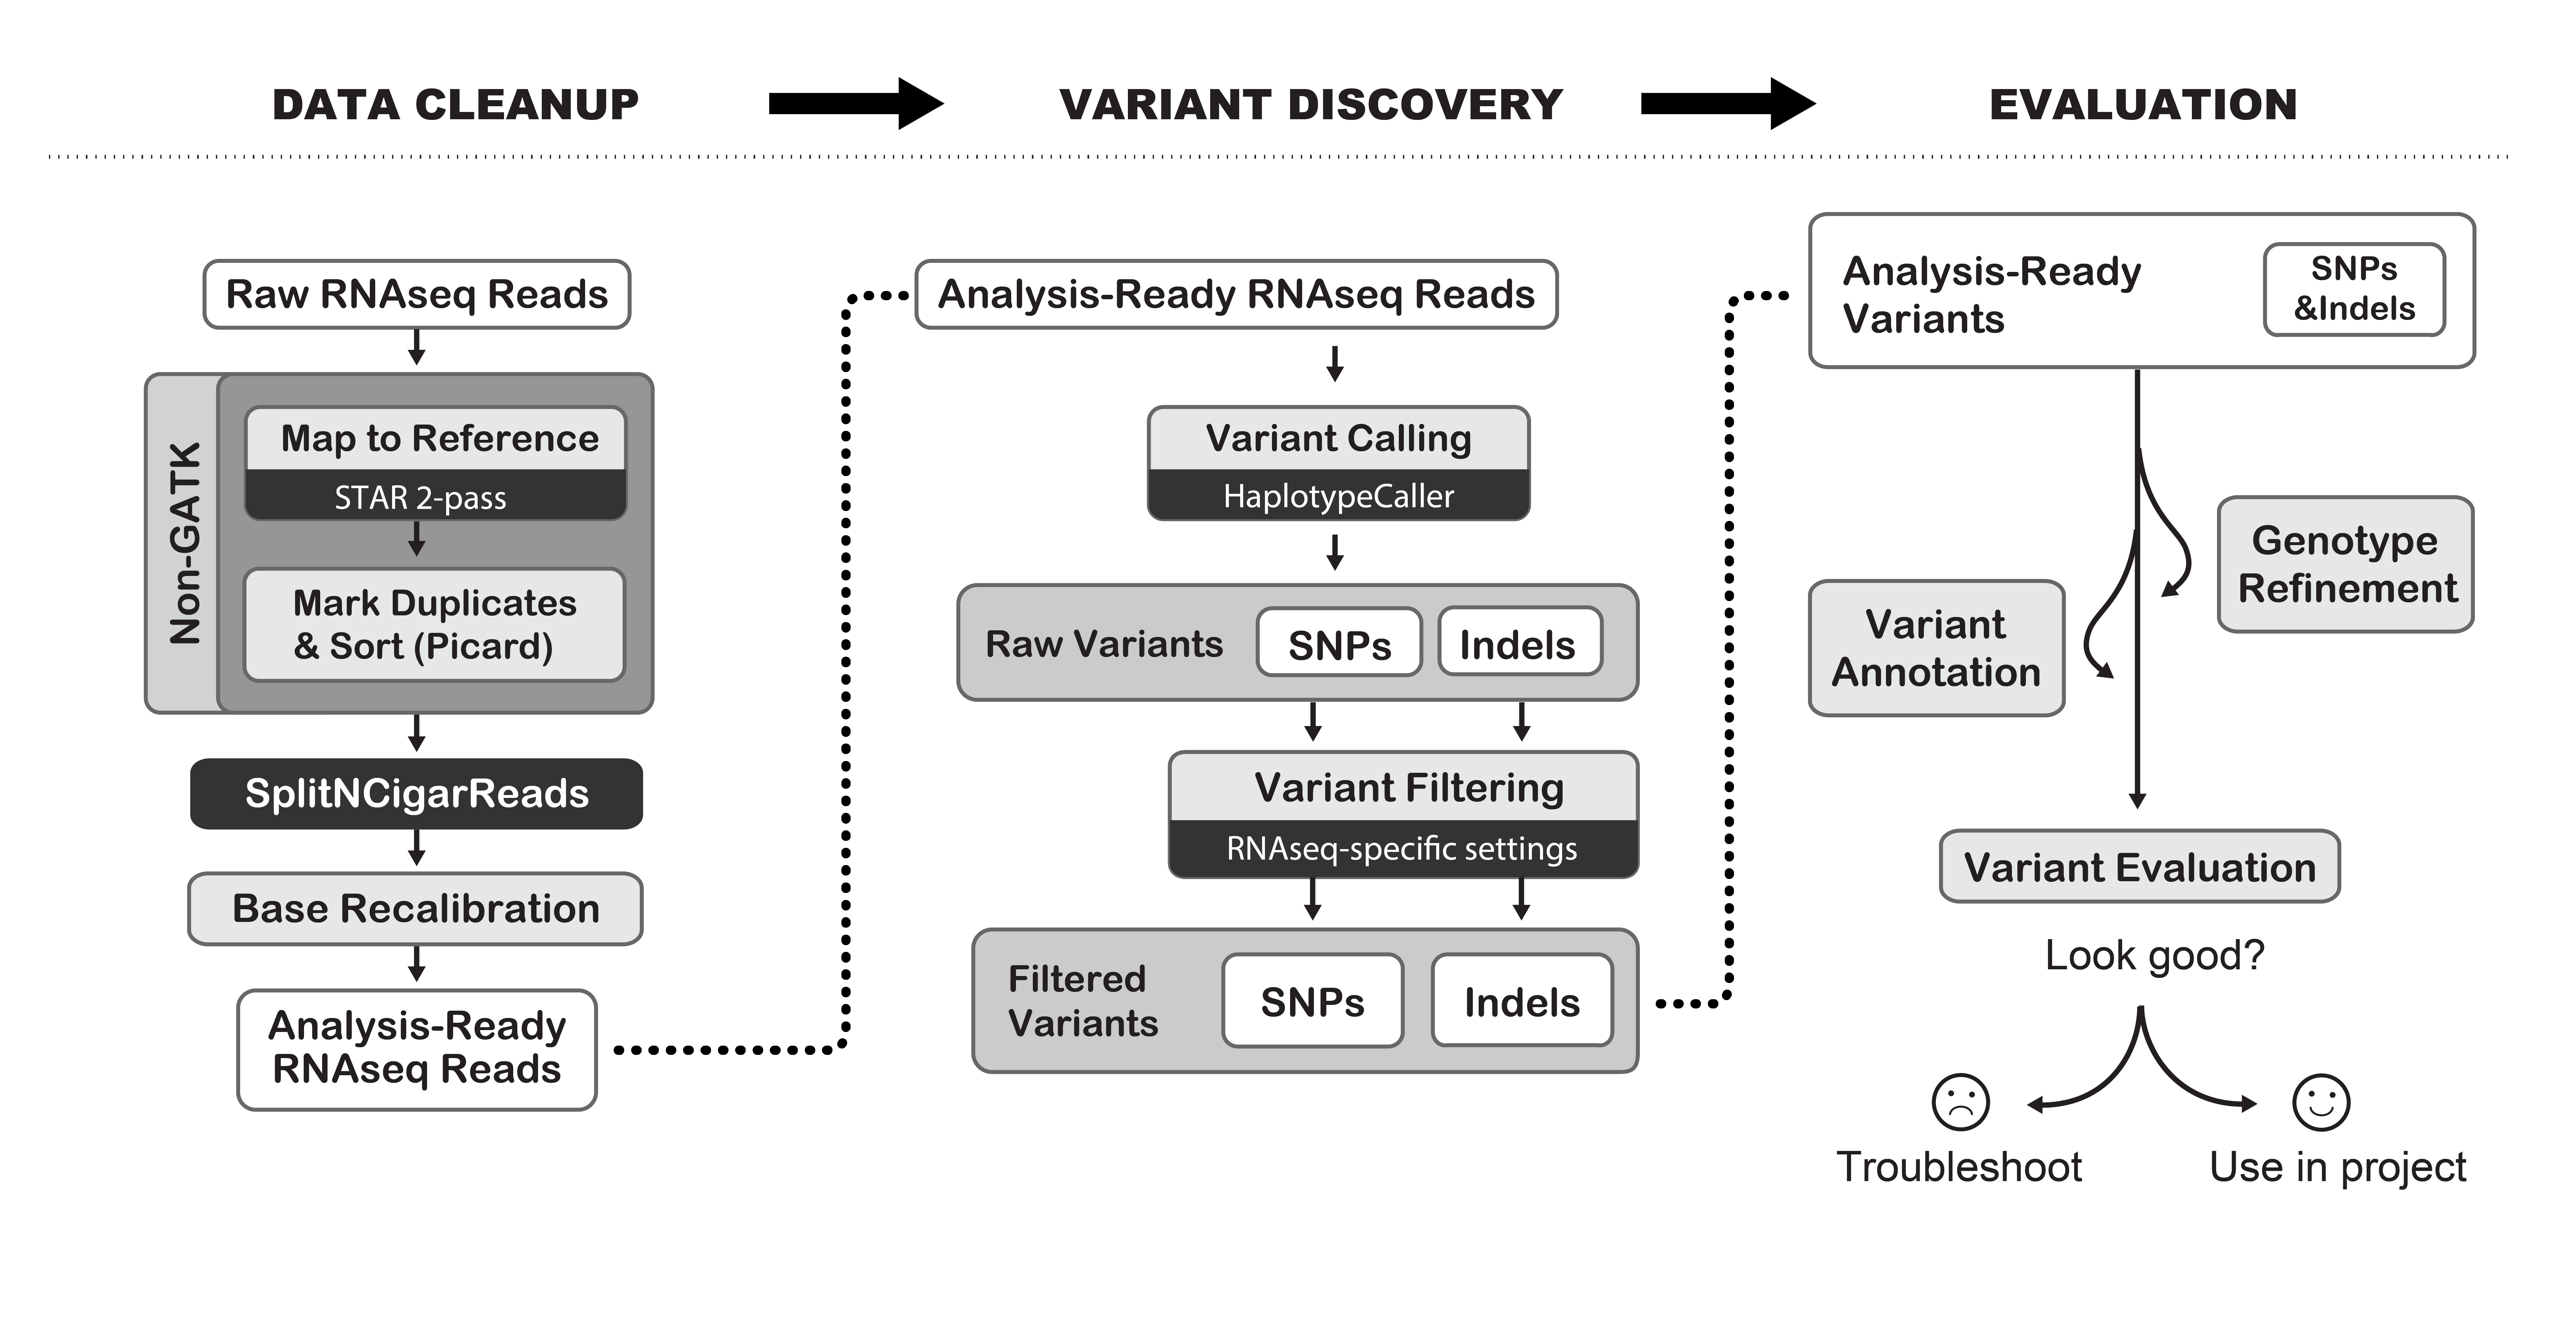

In [2]:
try:
    os.makedirs(os.path.join(DIR,"analysis/13_VariantCalling"))
except:
    print("13_VariantCalling Directory exists")
Image(filename=os.path.join(DIR,'images/GATK.jpeg')) 

### 13.1 Preprocessing. MarkDuplicates + BaseRecalibration

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$FASTQDIR" "$CLUSTERDIR" "$patients_summary" "$GENOMEDIR"

######################################DONE IN CLUSTER#####################################

sbatch $2/scripts/5_variant_calling/loop_prepro_GATK.sh $1 $2 $3 $4

### 13.2 Variant Calling

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" "$GENOMEDIR"

######################################DONE IN CLUSTER#####################################

sbatch $2/scripts/5_variant_calling/loop_variantcalling.sh $1 $2 $3 $4 

**VARIANT FILTERING**

Keep only those with PASS filter

In [42]:
%%bash -s "$DIR" "$patients_summary"

INDIR=$1/analysis/13_VariantCalling
module load tabix/0.2.6

cat $2 | while IFS=, read patient normal tumor; do
    zcat ${INDIR}/$patient/${patient}_filtered.vcf.gz | grep '^#\|PASS' > ${INDIR}/$patient/${patient}_filtered.PASS.vcf
    bgzip -c ${INDIR}/$patient/${patient}_filtered.PASS.vcf > ${INDIR}/$patient/${patient}_filtered.PASS.vcf.gz
    tabix -p vcf ${INDIR}/$patient/${patient}_filtered.PASS.vcf.gz
done

Second filter: DP > 10 && AD > 3 for RNAseq

In [60]:
INDIR=DIR+"/analysis/13_VariantCalling"

counter=0
for p in patients_id:
    patient_dir=os.path.join(INDIR,p)
    for file in os.listdir(patient_dir):
        if file.endswith("PASS.vcf"):
            outname=file[:-3]+"DP.AD.vcf"
            with open(os.path.join(patient_dir,outname), 'w') as out:
                with open(os.path.join(patient_dir,file)) as inp:
                    for line in inp.readlines():
                        if line.startswith('##'):
                            out.write(line)
                        elif line.startswith('#CHROM'):
                            header=line
                        else:
                            INFODP=line.split("\t")[7]
                            DP=INFODP.split(";")[2]
                            if header.split("\t")[10].strip() == tumor_id[counter]:
                                INFOAD=line.split("\t")[10]
                            else:
                                INFOAD=line.split("\t")[9]
                            AD=INFOAD.split(":")[1]
                            if (int(DP.split("=")[1]) > 10) and (int(AD.split(",")[1]) >= 3):
                                   out.write(line)
    counter = counter + 1

In [61]:
%%bash -s "$DIR" "$patients_summary"
INDIR=$1/analysis/13_VariantCalling

module load tabix/0.2.6

cat $2 | while IFS=, read patient normal tumor; do
    bgzip -c ${INDIR}/$patient/${patient}_filtered.PASS.DP.AD.vcf > ${INDIR}/$patient/${patient}_filtered.PASS.DP.AD.vcf.gz
    tabix -p vcf ${INDIR}/$patient/${patient}_filtered.PASS.DP.AD.vcf.gz
done

**VARIANT ANNOTATION** - Variant Effector Predictor (VEP) (https://www.ensembl.org/info/docs/tools/vep/script/vep_filter.html#:~:text=The%20VEP%20package%20includes%20a,same%20format%20can%20be%20used).)


In [62]:
%%bash -s "$DIR" "$GENOMEDIR" "$patients_summary"

INDIR=$1/analysis/13_VariantCalling
FASTADIR=$2/GRCh38/GRCh38.primary_assembly.genome.fa
CACHEDIR=/bicoh/MARGenomics/Ref_Genomes_fa/vep/98 # this need to be created

module load VEP/98

cat $3 | while IFS=, read patient normal tumor; do
    file=$INDIR/$patient/${patient}_filtered.PASS.DP.AD.vcf.gz
    output=${file%.vcf.gz}
    
    # Make .vep output
    vep -i $file -o ${output}.vep --dir_cache ${CACHEDIR} --cache --assembly GRCh38 --offline --force_overwrite --hgvs --fasta ${FASTADIR} --show_ref_allele --protein --biotype --symbol --af --af_gnomad
    # Make .vcf output
    vep -i $file -o ${output}.vep.vcf --vcf --dir_cache ${CACHEDIR} --cache --assembly GRCh38 --offline --force_overwrite --hgvs --fasta ${FASTADIR} --show_ref_allele --protein --biotype --symbol --af --af_gnomad

done

Select only non-synonimous mutations. **Indels are not considered, although it would be inetersting to do so**

In [7]:
%%bash -s "$DIR" "$GENOMEDIR" "$patients_summary"
INDIR=$1/analysis/13_VariantCalling
FASTADIR=$2/GRCh38/GRCh38.primary_assembly.genome.fa
CACHEDIR=/bicoh/MARGenomics/Ref_Genomes_fa/vep/98 # this need to be created

module load VEP/98

cat $3 | while IFS=, read patient normal tumor; do
    file=$INDIR/$patient/${patient}_filtered.PASS.DP.AD.vep
    output=${file%.vep}.missense.vep
    filter_vep -i ${file} -o ${output} --force_overwrite -filter "Consequence is missense_variant" and "gnomAD_AF < 0.05"

    output=${file%.vep}.missense.vcf
    filter_vep -i ${file}.vcf -o ${output} --force_overwrite -filter "Consequence is missense_variant" and "gnomAD_AF < 0.05"
done


**PEPTIDE PREDICTION**

In [64]:
file=os.path.join(GENOMEDIR,"/GRCh38/Homo_sapiens.GRCh38.pep.all.fa")
out=os.path.join(GENOMEDIR,"/GRCh38/Homo_sapiens.GRCh38.pep.all.noversion.fa")
with open(out, 'w') as o:
    with open(file) as f:
        for line in f:
            new_line = re.sub('\.\d+ '," ",line) # get rid of the version of the ENST identifiers
            o.write(new_line)

In [ ]:
%%bash -s "$DIR"

mkdir $1/analysis/13_VariantCalling/peptide_prediction

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" 

######################################DONE IN CLUSTER#####################################

sbatch $2/scripts/5_variant_calling/loop_snv2pep.sh $1 $2 $3 

**NetMHCpan**

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" 

######################################DONE IN CLUSTER#####################################

sbatch --array=1-9 $2/scripts/5_variant_calling/netmhcpan_VC.cmd $1 $2 $3 # --array=1-n where 9 is the number of files/patients to process

Generate a summary file with all mutated peptides

In [12]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC/variant_calling"

for p in patients_id:
    print(p)
    full_dir=INDIR+"/"+p
    for file in os.listdir(full_dir):
        if file.endswith('xls') and 'MT' in file:
            OUTFILE=full_dir+"/"+p+"_MT_peptides.csv" 
            temp=pd.DataFrame()
            netmhcpan=full_dir+"/"+file
            df = pd.read_csv(netmhcpan, sep="\t",skiprows=1)
            selected_df = df[['Peptide','ID','NB']]
            temp = selected_df[selected_df['NB'] > 0] #select mutated peptides with binding affinity
            temp.to_csv(OUTFILE, index=False)
            print(len(temp))

10615
31
10594
5
10584
16
10635
15
10632
15
10628
10627
6
10622
17
10619
9


Summary file variant calling peptides with affinity

In [15]:
transcript_gene=pd.read_csv(GENOMEDIR+"/GRCh38/biomart.v38.geneid_transid_genetype.csv",usecols=[0,1], names=['gene_id','ID'], skiprows=1)
INDIR=DIR+"/analysis/11_PeptideBindingMHC"

for p in patients_id:
    print(p)
    full_dir=INDIR+"/variant_calling/"+p
    summary_OUTFILE=full_dir+"/"+p+"_summary_total_peptides_VC.csv"
    with open(summary_OUTFILE, 'w') as out:
        out.write("type,num_peptids,num_peptids_affinity\n")
        for file in os.listdir(full_dir):
            if file.endswith(".xls") and 'MT' in file:
                netmhcpan=full_dir+"/"+file
                df = pd.read_csv(netmhcpan, sep="\t",skiprows=1)
                selected_df = df[['Peptide','ID','NB']]
                total_peptides = len(selected_df.index)
                temp = selected_df[selected_df['NB'] > 0]
                binding_AF = len(temp.index)
                out.write("MT,%s,%s\n"%(str(total_peptides),str(binding_AF)))



10615
10594
10584
10635
10632
10628
10627
10622
10619


Generate THE summary file with all the information for binding affinity.

Variant Calling resulted peptides, protein-coding peptides with affinity and novel classes of peptides with affinity but already filtered by GTEx.

In [16]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"
folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]

output=INDIR+"/binding_affinity_VC_GTEx.csv"
absolute_df = pd.DataFrame()

for p in patients_id:
    for f in folders:
        full_dir=INDIR+"/"+f+"/"+p+"/"
        if f == "variant_calling":
            file=full_dir+p+"_summary_total_peptides_VC.csv"
        else:
            file=full_dir+p+"_summary_total_peptides_GTEx.csv"
        df = pd.read_csv(file, header=0)

        df['patient'] = p
        absolute_df = pd.concat([absolute_df, df])

cols = list(absolute_df.columns)
cols = [cols[-1]] + cols[:-1]
absolute_df = absolute_df[cols]
absolute_df.to_csv(output, index=False)

Get a list of peptides per type (mutated, protein-coding, no-protein-coding, novel)

In [ ]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"

folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]
novel_pept_list = []
npc_pept_list = []
pc_pept_list=[]
vc_pept_list = []
for f in folders:
    for p in patients_id:
        if f == "noncanonical_CIPHER":
            pept_file = pd.read_csv(INDIR+"/"+f+"/"+p+"/"+p+"_peptides_GTEx.csv", header=0)
            novel = pept_file[pept_file['transcript_id'].str.contains('STRG')]
            novel_pept_list.extend(novel.Peptide.values.tolist())
            
            npc = pept_file[pept_file['transcript_id'].str.contains('ENST')]
            npc_pept_list.extend(npc.Peptide.values.tolist())
        if f == "canonical_CDS":
            pept_file = pd.read_csv(INDIR+"/"+f+"/"+p+"/"+p+"_peptides_GTEx.csv", header=0)
            pc_pept_list.extend(pept_file.Peptide.values.tolist())
        if f == "variant_calling":
            try:
                pept_file = pd.read_csv(INDIR+"/"+f+"/"+p+"/"+p+"_MT_peptides.csv", header=0)
                vc_pept_list.extend(pept_file.Peptide.values.tolist())
            except:
                continue
                
exclusive_npc = set(npc_pept_list)
print("noproteincoding - %i, %i removed" %(len(exclusive_npc),(len(npc_pept_list)-len(exclusive_npc))))
exclusive_npc_df = pd.DataFrame (exclusive_npc, columns = ['npc_peptide'])
exclusive_npc_df.to_csv(INDIR+"/exclusive_list_npc_peptides.csv", index=False)

exclusive_novel = set(novel_pept_list)
print("novel - %i, %i removed" %(len(exclusive_novel),(len(novel_pept_list)-len(exclusive_novel))))
exclusive_novel_df = pd.DataFrame (exclusive_novel, columns = ['novel_peptide'])
exclusive_novel_df.to_csv(INDIR+"/exclusive_list_novel_peptides.csv", index=False)

exclusive_pc = set(pc_pept_list)
print("protein-coding - %i, %i removed" %(len(exclusive_pc),(len(pc_pept_list)-len(exclusive_pc))))
exclusive_pc_df = pd.DataFrame (exclusive_pc, columns = ['pc_peptide'])
exclusive_pc_df.to_csv(INDIR+"/exclusive_list_pc_peptides.csv", index=False)

exclusive_vc = set(vc_pept_list)
print("variant calling - %i, %i removed" %(len(exclusive_vc),(len(vc_pept_list)-len(exclusive_vc))))
exclusive_vc_df = pd.DataFrame (exclusive_vc, columns = ['vc_peptide'])
exclusive_vc_df.to_csv(INDIR+"/exclusive_list_vc_peptides.csv", index=False)